In [58]:
import torch

import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import os

from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from torch.utils.data import DataLoader, SequentialSampler

import sys
sys.path.append("..")
from src.image_data import ImageClassificationDataset
from src.quantize import cluster_feat

### Download and View Data

In [2]:
dataset = load_dataset("zh-plus/tiny-imagenet")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
train = dataset['train']
val = dataset['valid']

In [44]:
def create_x_y(dat):
    image = dat['image']
    label = dat['label']

    count = 0
    out = []
    for img in tqdm(image):
        x_i = np.array(img)
        if x_i.shape != (64, 64, 3):
            out.append(np.tile(x_i[..., None], 3))
            count += 1
        else:
            out.append(x_i)
    out = np.array(out)
    print(f"tiled {count / len(image)} proportion of images to color")
    print(f"final shape: {out.shape}")

    return out, np.array(label)

In [45]:
x_train, y_train = create_x_y(train)
x_test, y_test =  create_x_y(val)

100%|██████████| 100000/100000 [00:01<00:00, 56819.38it/s]


tiled 0.01821 proportion of images to color
final shape: (100000, 64, 64, 3)


100%|██████████| 10000/10000 [00:00<00:00, 74076.83it/s]

tiled 0.0168 proportion of images to color
final shape: (10000, 64, 64, 3)


In [47]:
print(x_train[0, :, :, 0])
print(x_train.shape)
print(y_train.shape)
print(len(np.unique(y_train)))

[[255 255 246 ... 208 207 125]
 [255 255 246 ... 203 200 121]
 [255 255 255 ... 207 200 119]
 ...
 [ 94  93  93 ...  85  78  94]
 [ 89  88  87 ...  86  77  87]
 [ 91  91  91 ...  96  77  72]]
(100000, 64, 64, 3)
(100000,)
200


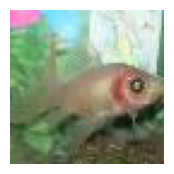

In [49]:
image = x_train[0]

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(image)
plt.show()

In [51]:
root = "/mnt/ssd/ronak/datasets/tiny_imagenet/"

np.save(os.path.join(root, "x_train.npy"), x_train)
np.save(os.path.join(root, "y_train.npy"), y_train)
np.save(os.path.join(root, "x_test.npy"), x_test)
np.save(os.path.join(root, "y_test.npy"), y_test)

### Embed with ConvNeXt Model

In [64]:
DATA_PATH = '/mnt/ssd/ronak/datasets/tiny_imagenet'
DEVICE = 'cuda:2'

In [65]:
model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1).to(DEVICE)
# train_nodes, eval_nodes = get_graph_node_names(model) # use to check layer names

In [66]:
return_nodes = {
    # node_name: user-specified key for output dict
    'avgpool': 'features',
}
body = create_feature_extractor(model, return_nodes=return_nodes)

In [67]:
root = DATA_PATH
x_train = np.transpose(np.load(os.path.join(root, "x_train.npy")), axes=[0, 3, 1, 2])
# x_train = np.transpose(np.tile(x_train[..., None], 3), axes=[0, 3, 1, 2])
y_train = np.load(os.path.join(root, "y_train.npy"))
print(x_train.shape)
print(y_train.shape)

batch_size = 256
transforms = ConvNeXt_Base_Weights.IMAGENET1K_V1.transforms()
train_dataset = ImageClassificationDataset(x_train, y_train, transforms)
dataloader = DataLoader(
    train_dataset, sampler=SequentialSampler(train_dataset), batch_size=batch_size
)

(100000, 3, 64, 64)
(100000,)


In [68]:
all_image_features, all_labels, all_idx = [], [], []
with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader)):
        idx, images, labels = batch
        image_features = body(images.to(DEVICE))['features'].squeeze()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features)
        all_labels.append(labels)
        all_idx.append(idx)
        
all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
all_labels = torch.cat(all_labels).cpu().detach().numpy()
all_idx = torch.cat(all_idx).cpu().detach().numpy()

torch.save(all_image_features, os.path.join(DATA_PATH, "convnext_base_features.pt"))
torch.save(all_labels, os.path.join(DATA_PATH, "convnext_base_labels.pt"))
torch.save(all_idx, os.path.join(DATA_PATH, "convnext_base_idx.pt"))

0it [00:00, ?it/s]/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
391it [14:28,  2.22s/it]


### Apply Quantization

In [69]:
NUM_CLUSTERS = 50
SEED = 11182023
DATASET = "tiny_imagenet"
DATA_PATH = f'/mnt/ssd/ronak/datasets/{DATASET}'

In [70]:
all_image_features = torch.load(os.path.join(DATA_PATH, "convnext_base_features.pt"))
all_labels = torch.load(os.path.join(DATA_PATH, "convnext_base_labels.pt"))
all_idx = torch.load(os.path.join(DATA_PATH, "convnext_base_idx.pt"))

In [71]:
image_labels, image_cluster = cluster_feat(all_image_features, NUM_CLUSTERS, seed=SEED)

label_to_idx = np.argsort(all_idx)
print(all_idx[label_to_idx])

# have the labels correspond to the indices in order.
image_labels_sorted = image_labels[label_to_idx]
class_labels_sorted = all_labels[label_to_idx]

print(image_labels_sorted.shape)
print(class_labels_sorted.shape)

[    0     1     2 ... 99997 99998 99999]
(100000,)
(100000,)


In [72]:
model_name = "convnext_base"
save_dir = f'/mnt/ssd/ronak/datasets/{DATASET}/quantization/{model_name}_kmeans_{NUM_CLUSTERS}'

os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, f'image_labels.npy'), image_labels_sorted)
np.save(os.path.join(save_dir, f'class_labels.npy'), class_labels_sorted)

_, counts = np.unique(all_labels, return_counts=True)
y_marginal = counts / np.sum(counts)
x_marginal = image_cluster.marginal

np.save(os.path.join(save_dir, f'image_marginal.npy'), x_marginal)
np.save(os.path.join(save_dir, f'class_marginal.npy'), y_marginal)